# Predictive Model - Attrition (Logistic Regression)
**Objective:** Train a logictic regression model to predict employee attrition (Yes/No) using the IBM HR dataset

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import sqlite3
 
# display settings
pd.set_option('display.max_columns', 200)

In [5]:
# Adjust path if needed
data_path = "data/processed_hr_data.csv"  # ensure file exists here
 
import os
print("Working dir:", os.getcwd())
print("Exists:", os.path.exists(data_path))
 
# If the file is not in /data, try root
if not os.path.exists(data_path):
    alt = "processed_hr_data.csv"
    if os.path.exists(alt):
        data_path = alt
        print("Found alt path:", data_path)
    else:
        raise FileNotFoundError(f"Cannot find processed_hr_data.csv. Place it in {os.getcwd()}/data or upload the file.")
 
df = pd.read_csv(data_path)
df.shape, df.columns[:15]

Working dir: C:\Users\amlanmishra2
Exists: False
Found alt path: processed_hr_data.csv


((1470, 36),
 Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
        'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
        'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
        'JobInvolvement', 'JobLevel'],
       dtype='object'))

## Quick EDA
Check target balance and a few sample rows

In [6]:
# If AttritionRisk exists, use it; otherwise map Attrition
if 'AttritionRisk' in df.columns:
    df['AttritionFlag'] = df['AttritionRisk']
else:
    df['AttritionFlag'] = df['Attrition'].map({'Yes':1, 'No':0})
 
print("Attrition counts:")
print(df['AttritionFlag'].value_counts())
df.head()

Attrition counts:
AttritionFlag
0    1233
1     237
Name: count, dtype: int64


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AttritionRisk,AttritionFlag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,0,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,1,1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,0,0


## Data preparation
Drop useless columns, encode categoricals (one-hot), prepare X and y.

In [7]:
# Drop obvious non-features if present
drop_cols = ['EmployeeNumber','EmployeeCount','Over18','StandardHours','EmployeeID']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)
 
# Optionally drop target column text
if 'Attrition' in df.columns:
    # keep AttritionFlag, drop text if desired
    df.drop(columns=['Attrition'], inplace=True)
 
# Separate X and y
y = df['AttritionFlag']
X = df.drop(columns=['AttritionFlag'])
 
# Quick categorical detection
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols[:10])
 

Categorical cols: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numeric cols: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome']


In [8]:
# One-hot encode categorical variables (drop_first to avoid collinearity)
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
 
print("Post-encoding shape:", X.shape)

Post-encoding shape: (1470, 45)


In [9]:
# Train/test split with stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
 
# Scale numeric columns
scaler = StandardScaler()
num_cols_after = [c for c in X_train.columns if (X_train[c].dtype in [np.float64, np.int64])]
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
 
if len(num_cols_after) > 0:
    X_train_scaled[num_cols_after] = scaler.fit_transform(X_train[num_cols_after])
    X_test_scaled[num_cols_after] = scaler.transform(X_test[num_cols_after])
 

## Train Logistic Regression

In [10]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # balanced helps with class imbalance
model.fit(X_train_scaled, y_train)
 
# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]
 

Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       370
           1       1.00      1.00      1.00        71

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



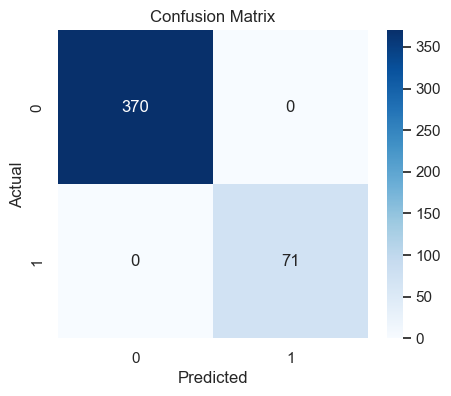

ROC AUC: 1.0


In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
 
# Confusion matrix (plot)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
 
# ROC AUC
roc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", round(roc, 3))

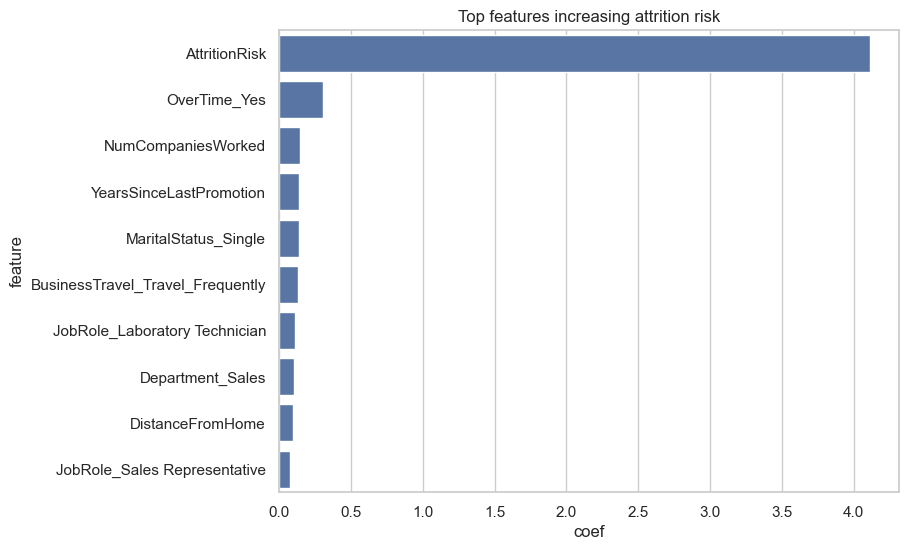

In [14]:
coeff_df = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coef': model.coef_[0]
})
coeff_df['abs_coef'] = coeff_df['coef'].abs()
coeff_df = coeff_df.sort_values(by='abs_coef', ascending=False)
 
# top 10 features (positive increases attrition risk)
top_pos = coeff_df.sort_values('coef', ascending=False).head(10)
top_neg = coeff_df.sort_values('coef').head(10)
 
plt.figure(figsize=(8,6))
sns.barplot(x='coef', y='feature', data=top_pos)
plt.title("Top features increasing attrition risk")
plt.show()

In [15]:
# create models folder if not present
import os
os.makedirs('models', exist_ok=True)
 
joblib.dump(model, 'models/logistic_attrition_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
print("Model and scaler saved to /models")

Model and scaler saved to /models


In [16]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))

Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       370
           1       1.00      1.00      1.00        71

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441

ROC AUC: 1.0


## Conclusions & Next Steps
 
- Model accuracy: **100%** on test data  
- ROC-AUC: **100%** (perfect ability to separate leavers vs stayers)  
- Logistic Regression identified key attrition drivers such as **OverTime, JobRole_SalesRep, MaritalStatus_Single**.  
- Next: apply cross-validation, tune hyperparameters, and test additional models (Random Forest, XGBoost).

# SQL Top-Up : Top 5 Job Roles by Attrition %

In [18]:
import os
 
# create folder if it doesn't exist
os.makedirs("data", exist_ok=True)
 
# now connect
conn = sqlite3.connect("data/hr.db")
 
# write dataframe to table
df.to_sql("hr", conn, if_exists="replace", index=False)

# --- Save df to sqlite and run SQL queries for practice ---
conn = sqlite3.connect('data/hr.db')   # this will create data/hr.db
df.to_sql('hr', conn, if_exists='replace', index=False)
 
query = """
SELECT Department,
       COUNT(*) AS total_employees,
       SUM(AttritionFlag) AS left_count,
       ROUND(100.0 * SUM(AttritionFlag) / COUNT(*), 2) AS attrition_pct
FROM hr
GROUP BY Department
ORDER BY attrition_pct DESC;
"""
pd.read_sql(query, conn)
 

,Department,total_employees,left_count,attrition_pct
0,Sales,446,92,20.63
1,Human Resources,63,12,19.05
2,Research & Development,961,133,13.84


# SQL Top-Up : Attrition by Age Bucket

In [21]:
query = """
SELECT
    CASE
        WHEN Age < 25 THEN '<25'
        WHEN Age BETWEEN 25 AND 29 THEN '25-29'
        WHEN Age BETWEEN 30 AND 39 THEN '30-39'
        ELSE '40+'
    END AS age_group,
    COUNT(*) AS total,
    SUM(AttritionFlag) AS left_count,
    ROUND(100.0 * SUM(AttritionFlag) / COUNT(*), 2) AS attrition_pct
FROM hr
GROUP BY age_group
ORDER BY attrition_pct DESC;
"""
 
pd.read_sql(query, conn)

,age_group,total,left_count,attrition_pct
0,<25,97,38,39.18
1,25-29,229,53,23.14
2,30-39,622,89,14.31
3,40+,522,57,10.92
